
=== LogisticRegression ===
Acurácia (treino): 0.9944
Acurácia (teste):  0.9905
Relatório de classificação:
               precision    recall  f1-score   support

   Excellent       0.97      0.96      0.96       270
        Fair       1.00      1.00      1.00       410
        Good       0.99      0.99      0.99      1128
        Poor       1.00      1.00      1.00       192

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



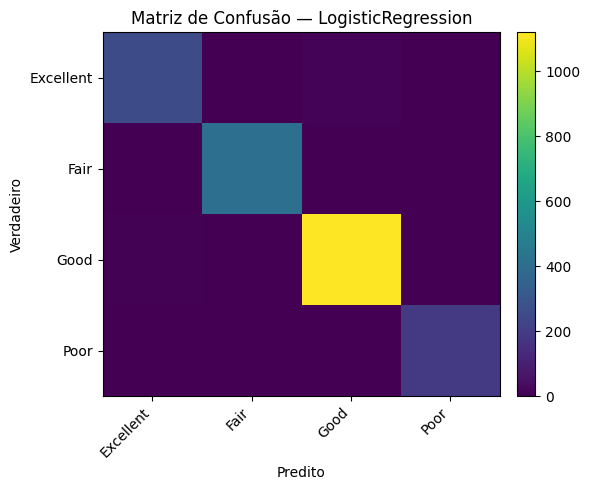


=== RandomForest ===
Acurácia (treino): 1.0000
Acurácia (teste):  0.9915
Relatório de classificação:
               precision    recall  f1-score   support

   Excellent       0.98      0.96      0.97       270
        Fair       1.00      1.00      1.00       410
        Good       0.99      1.00      0.99      1128
        Poor       1.00      1.00      1.00       192

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



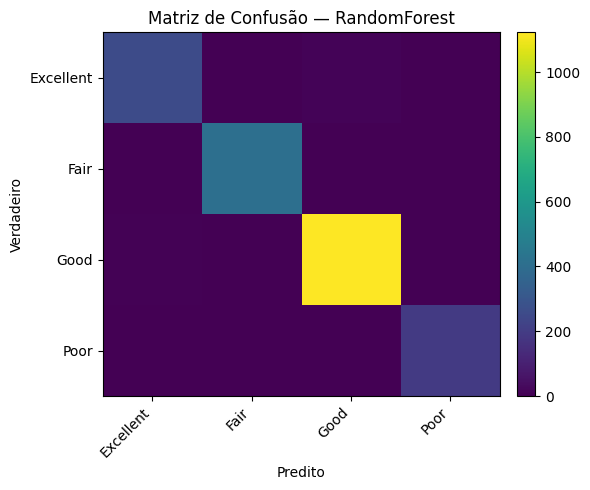


=== Comparação geral ===
LogisticRegression: acc_train=0.994 | acc_test=0.991
RandomForest: acc_train=1.000 | acc_test=0.992

Melhor modelo: RandomForest | acc_test=0.992 — equilíbrio razoável


['hla_best_model.pkl']

In [2]:
# ============================================================
# Health&Life Analytics — Classificação de Sleep_Quality
# Tarefas:
#  - Pré-processar (imputação, OHE, padronização)
#  - Criar features derivadas
#  - Train/Test split
#  - Treinar 2 modelos (LogisticRegression, RandomForest)
#  - Avaliar: acurácia, classification_report, matriz de confusão
#  - Diagnóstico de over/underfitting
#  - Salvar CSV processado e melhor modelo (pipeline completo)
#  - Recomendações para o Negócio (prints)
# Requisitos: pandas, numpy, scikit-learn, matplotlib, joblib
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ------------------------------------------------------------------------------
# 1) Configurações
# ------------------------------------------------------------------------------
FILE = "synthetic_coffee_health_10000(in).csv"  # ajuste o caminho se necessário
PROCESSED_CSV_PATH = "hla_processed_dataset.csv"
BEST_MODEL_PATH = "hla_best_model.pkl"
RANDOM_STATE = 42
TEST_SIZE = 0.20

# ------------------------------------------------------------------------------
# 2) Helpers
# ------------------------------------------------------------------------------
def guess(df: pd.DataFrame, keys):
    """Tenta localizar a coluna pelo nome (case-insensitive) e por substring."""
    lower = {c.lower(): c for c in df.columns}
    for k in keys:
        if k.lower() in lower:
            return lower[k.lower()]
    for c in df.columns:
        if any(k in c.lower() for k in keys):
            return c
    return None

def to_ordinal(name: str, s: pd.Series) -> pd.Series:
    """Converte série categórica para escala numérica ordinal quando possível."""
    if s is None:
        return None
    if pd.api.types.is_numeric_dtype(s):
        return s
    s_num = pd.to_numeric(s, errors="coerce")
    if s_num.notna().mean() > 0.80:
        return s_num
    vals = s.astype(str).str.strip().str.lower()
    name_l = name.lower()
    # Estresse: ordens comuns
    if "stress" in name_l:
        orders = [
            ["very low","low","moderate","high","very high"],
            ["low","medium","high"]
        ]
        for order in orders:
            if set(vals.unique()).issubset(set(order)) or set(order).issubset(set(vals.unique())):
                return vals.map({lab:i+1 for i, lab in enumerate(order)})
    # Fallback: códigos inteiros (não garante semântica)
    return pd.Series(pd.Categorical(vals).codes + 1, index=s.index, name=s.name)

def build_preprocessor(X: pd.DataFrame) -> ColumnTransformer:
    """ColumnTransformer com imputação + scale (numéricas) e imputação + OHE (categóricas)."""
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    # Compatibilidade sklearn (sparse_output em versões novas; sparse nas antigas)
    try:
        categorical_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ])
    except TypeError:
        categorical_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
        ])

    pre = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder="drop"
    )
    return pre

def evaluate_model(name: str, pipe: Pipeline, X_train, y_train, X_test, y_test):
    """Treina, avalia, imprime métricas e plota matriz de confusão."""
    pipe.fit(X_train, y_train)

    # Acurácia treino/teste
    y_pred_tr = pipe.predict(X_train)
    y_pred = pipe.predict(X_test)
    acc_tr = accuracy_score(y_train, y_pred_tr)
    acc = accuracy_score(y_test, y_pred)

    # Relatório de classificação
    report_text = classification_report(y_test, y_pred, zero_division=0)

    # Matriz de confusão (labels ordenados)
    labels = sorted(pd.unique(y_test))
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    print(f"\n=== {name} ===")
    print(f"Acurácia (treino): {acc_tr:.4f}")
    print(f"Acurácia (teste):  {acc:.4f}")
    print("Relatório de classificação:\n", report_text)

    # Plot da matriz de confusão (matplotlib puro, 1 figura)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, aspect="auto")
    plt.title(f"Matriz de Confusão — {name}")
    plt.xlabel("Predito"); plt.ylabel("Verdadeiro")
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    return {
        "pipeline": pipe,
        "acc_train": acc_tr,
        "acc_test": acc,
        "report_text": report_text,
        "cm": cm,
        "labels": labels
    }

def export_processed_csv(X: pd.DataFrame, y: pd.Series, path: str):
    """Ajusta um preprocessor novo em TODO o X e exporta a matriz transformada + alvo."""
    pre = build_preprocessor(X)
    pre.fit(X)
    X_all = pre.transform(X)

    # Nomes de features (se suportado)
    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        feature_names = [f"f_{i}" for i in range(X_all.shape[1])]

    proc = pd.DataFrame(X_all, columns=feature_names)
    proc["target_Sleep_Quality"] = y.values
    proc.to_csv(path, index=False)
    return path

def extract_top_features_from_best(pipeline: Pipeline, topk=10):
    """Retorna nomes das top features (importância ou norma do coef)."""
    try:
        pre = pipeline.named_steps["preprocess"]
        try:
            names = pre.get_feature_names_out()
        except Exception:
            # fallback: tenta inferir dimensionalidade
            names = [f"feat_{i}" for i in range(pre.transform(pd.DataFrame([{}])).shape[1])]
        model = pipeline.named_steps["model"]
        if hasattr(model, "feature_importances_"):
            imp = model.feature_importances_
            order = np.argsort(imp)[::-1][:topk]
            return [(names[i], float(imp[i])) for i in order]
        elif hasattr(model, "coef_"):
            # Para multiclasse: usa norma ao longo das classes
            coefs = np.linalg.norm(model.coef_, axis=0)
            order = np.argsort(coefs)[::-1][:topk]
            return [(names[i], float(coefs[i])) for i in order]
    except Exception:
        pass
    return []

# ------------------------------------------------------------------------------
# 3) Carregar e preparar dados
# ------------------------------------------------------------------------------
df = pd.read_csv(FILE)

# Remoção de IDs/irrelevantes
drop_cols = [c for c in df.columns if c.lower() in ["id", "identifier", "user_id"]]
df = df.drop(columns=drop_cols, errors="ignore")

# Detectar colunas relevantes
col_target   = guess(df, ["sleep_quality","sleep_score","sleep_rating"])
col_caffeine = guess(df, ["caffeine_mg","coffee","coffee_intake","coffee_cups","coffee_cups_per_day"])
col_sleep    = guess(df, ["sleep_hours","sleep_duration","hours_of_sleep"])
col_sys      = guess(df, ["blood_pressure_sys","systolic"])
col_dia      = guess(df, ["blood_pressure_dia","diastolic"])
col_stress   = guess(df, ["stress_level","stress"])
col_age      = guess(df, ["age","idade"])

assert col_target is not None, "Coluna-alvo 'Sleep_Quality' não encontrada."

# Features derivadas (exemplos simples e úteis)
if (col_caffeine is not None) and (col_sleep is not None):
    df["Caffeine_per_SleepHour"] = df[col_caffeine] / df[col_sleep].replace(0, np.nan)
if (col_sys is not None) and (col_dia is not None):
    df["Pulse_Pressure"] = df[col_sys] - df[col_dia]
if col_stress is not None:
    df["Stress_Num"] = to_ordinal(col_stress, df[col_stress])

# X e y
y = df[col_target].astype(str)       # mantém rótulos legíveis
X = df.drop(columns=[col_target])    # todas as demais colunas (inclui derivadas)

# ------------------------------------------------------------------------------
# 4) Split, Modelos e Avaliação
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Pipelines dos modelos
preprocess = build_preprocessor(X_train)

clf_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000))  # solver lbfgs default, robusto p/ multiclasse
])

clf_rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE))
])

# Treinar/avaliar
results = {}
results["LogisticRegression"] = evaluate_model("LogisticRegression", clf_lr, X_train, y_train, X_test, y_test)
results["RandomForest"]       = evaluate_model("RandomForest",       clf_rf, X_train, y_train, X_test, y_test)

# Melhor por acurácia de TESTE
best_name = max(results.keys(), key=lambda k: results[k]["acc_test"])
best = results[best_name]

# Diagnóstico simples de ajuste
gap = best["acc_train"] - best["acc_test"]
diagnosis = "equilíbrio razoável"
if gap > 0.10:
    diagnosis = "possível OVERFITTING (grande diferença treino>teste)"
elif best["acc_test"] < 0.50:
    diagnosis = "possível UNDERFITTING (baixa performance)"

print("\n=== Comparação geral ===")
for k, r in results.items():
    print(f"{k}: acc_train={r['acc_train']:.3f} | acc_test={r['acc_test']:.3f}")
print(f"\nMelhor modelo: {best_name} | acc_test={best['acc_test']:.3f} — {diagnosis}")

# ------------------------------------------------------------------------------
# 5) Exportar dataset processado (para reuso/BI) e salvar melhor modelo
# ------------------------------------------------------------------------------
csv_path = export_processed_csv(X, y, PROCESSED_CSV_PATH)
joblib.dump(best["pipeline"], BEST_MODEL_PATH)
